# Support points with Exponential Mechanism

### Procedure:


1. Given data $X = \{x_1, \ldots, x_M\}$ on space $\mathcal{D} \in [0, 1]^d$, find optimal support points $Y = \{y_1, \ldots, y_N\}$.
2. Using energy distance (with Lp norm) as the score function of the exponential mechanism, the sensitivity is $\Delta f = \frac{2 d^{1/p}(2N - 1)}{N^2}$. The exponential mechanism samples a new energy value $\tilde{e} \sim \mbox{Exp}(\frac{2\Delta f}{\alpha})$, where $\alpha$ is the privacy budget.
3. Let $\tilde{Y}$ be a copy of $Y$. While $e(\tilde{Y}, Y) < \tilde{e}$, perturb all points in $\tilde{Y}$ with small step in a random direction.


___

# 0. Helper Functions

In [1]:
%matplotlib inline

import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pdb
from scipy.spatial.distance import pdist
import sys
import tensorflow as tf
import time

from data import load_balog_data
from sp_utils import (
    get_support_points,
    energy,
    sample_sp_exp_mech,
    mixture_model_likelihood,
    sample_full_set_by_diffusion)

matplotlib.rcParams.update({'font.size': 14})
plt.style.use('ggplot')
print(sys.version)
print(tf.__version__)

3.7.1 (default, Nov 28 2018, 11:55:14) 
[Clang 9.0.0 (clang-900.0.39.2)]
1.13.1


In [2]:
np.random.seed(123)

____

# 1. Global Config

In [3]:
# Set global constants.          # main1()
IS_TF = True                     # Boolean. Use TensorFlow rather than analytical gradients.
Y_INIT_OPTION = 'radial'         # ['grid', 'random', 'radial']
MAX_ITER = 301                   # Num iterations in each support point optimization. [301]
LR = 1e-2                        # Energy optimization learning rate. [1e-2]

M = 200                          # Number of data points.
DIM = 2                          # Dimension of data.
C = 10                           # Number of clusters in data.
SIGMA_DATA = 0.02                # Bandwidth of data.

ENERGY_POWER = 2.                # Power for energy distance kernel.
ALPHA = 50                       # Differential privacy level.
N = 20                           # Number of support points.
STEP_SIZE = 1e-3                 # Diffusion and MH step sizes.
NUM_Y_TILDES = 500               # Number of samples of support points.

___

# 2. Load and Plot Data

In [4]:
# Load data.
x = load_balog_data(M, DIM, C, SIGMA_DATA, make_new=True, do_weighted=True)

Loaded M=200, DIM=2, SIG=0.02, C=10


___

# 3. Run Support Point Optimization

is_tf: True, y_init: radial, clip: bounds, wlb: False

  [*] Using TensorFlow optimization.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
  [*] Overall it/s: 0.0040


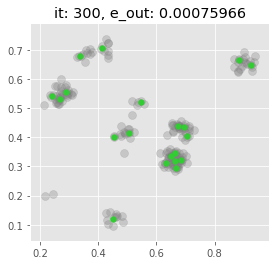

Time elapsed: 1.3749220371246338


In [5]:
# Compute m support points on full set.
y_opt, e_opt = get_support_points(x, N, MAX_ITER, LR, is_tf=IS_TF)

#### Paper: Figure of support point optimization for variety of cluster sizes and counts.

In [6]:
if 0:
    example_sigmas = [0.02, 0.04]
    example_clusters = [5, 10, 15]
    n_sig = len(example_sigmas)
    n_clu = len(example_clusters)

    fig, axs = plt.subplots(n_sig, n_clu, figsize=(5 * n_clu, 5 * n_sig))
    for i, sigma in enumerate(example_sigmas):
        for j, cluster_count in enumerate(example_clusters):
            temp_data = load_balog_data(M, DIM, cluster_count, sigma, make_new=True,
                                        do_weighted=False)
            temp_y_opt, temp_e_opt = get_support_points(temp_data, N, MAX_ITER,
                                                        LR, is_tf=IS_TF, plot=False)

            axs[i, j].set_title('$\sigma$={}, C={}'.format(sigma, cluster_count))
            axs[i, j].scatter(temp_data[:, 0], temp_data[:, 1], c='gray', alpha=0.3)
            axs[i, j].scatter(temp_y_opt[:, 0], temp_y_opt[:, 1], c='green', alpha=0.7)
            axs[i, j].set_xlim((0, 1))
            axs[i, j].set_ylim((0, 1))


    plt.subplots_adjust(wspace=0.2, hspace=0.2,
                        bottom=0.1, top=0.9, left=0.1, right=0.9)
    plt.savefig('../output/fig_sp_optimization.png')

___

# 4. Define sensitivity.

In [7]:
# Define energy sensitivity for Exponential Mechanism.
# OLD: energy_sensitivity = 2 * DIM ** (1. / ENERGY_POWER) / N ** 2
energy_sensitivity = 2 * DIM ** (1. / ENERGY_POWER) * (2 * N - 1) / N ** 2
print(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
       '= Exp({:.3f})').format(energy_sensitivity, ALPHA, 
                               2. * energy_sensitivity / ALPHA))

Exp(2 * U / alpha) = Exp(2 * 0.2758 / 50.00) = Exp(0.011)


___

# 5. Sample support points.



--------- RUNNING MH ----------


Pr(e) ~ Exp(2U/a) = a / (2U) * exp(- a / (2U) * e) = Exp(2 * 0.2758 / 10000.000) = Exp(0.0001)

Running chain. Length=41000, Burn=1000, Thin=200, Step=0.001
Difference factor: 18130.94


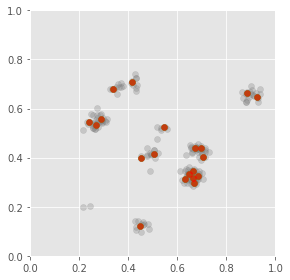

Acceptance rate: 0.0
Energy diff: -0.00015236


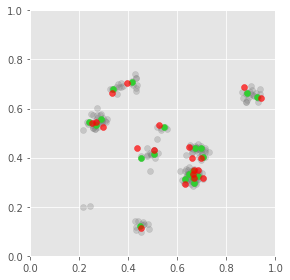

Acceptance rate: 0.7206396801599201
Energy diff: -0.00010371


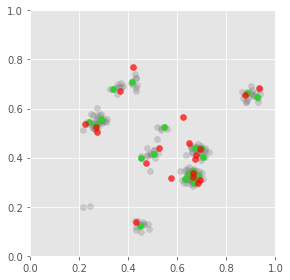

Acceptance rate: 0.7293176705823544
Energy diff: -0.00001729


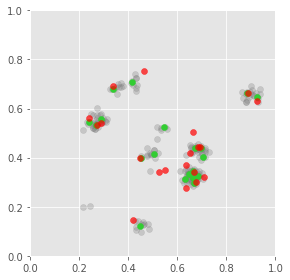

Acceptance rate: 0.7303782702882853
Energy diff: 0.00003090


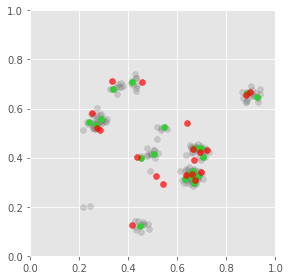

Acceptance rate: 0.7319085114360705
Energy diff: 0.00000859


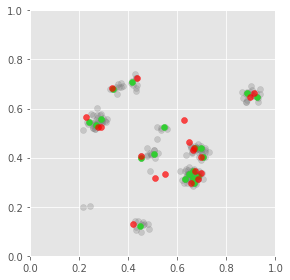

Acceptance rate: 0.7327267273272673
Energy diff: 0.00002997


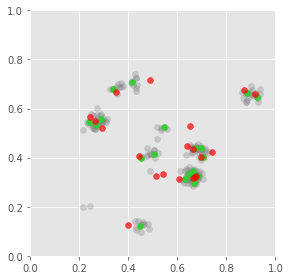

Acceptance rate: 0.7319390050829098
Energy diff: -0.00000421


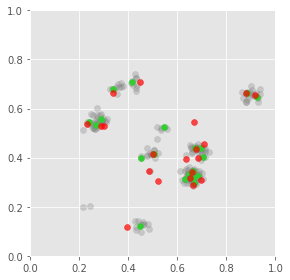

Acceptance rate: 0.7307335190343547
Energy diff: 0.00007930


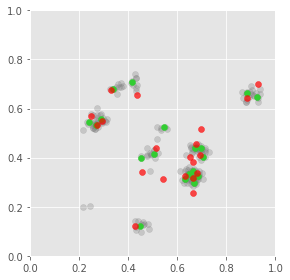

Acceptance rate: 0.7321417411411787
Energy diff: -0.00003353


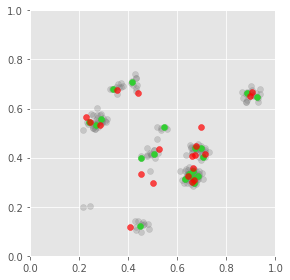

Acceptance rate: 0.7308482862063219
Energy diff: 0.00001459


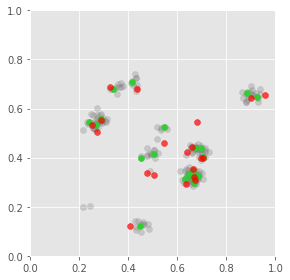

Acceptance rate: 0.7307634618269087
Energy diff: -0.00004196


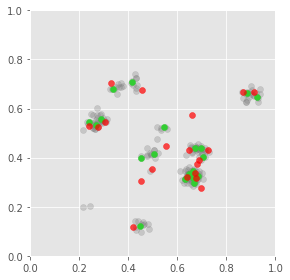

Acceptance rate: 0.7307849643198037
Energy diff: -0.00004107


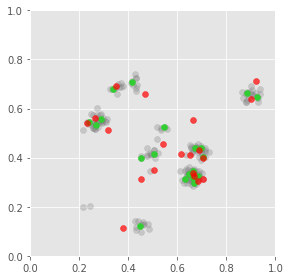

Acceptance rate: 0.7321361609932919
Energy diff: 0.00001324


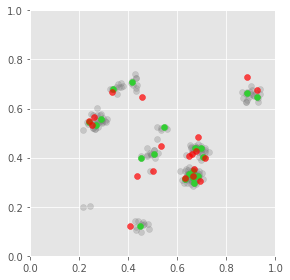

Acceptance rate: 0.7326256682435291
Energy diff: 0.00004030


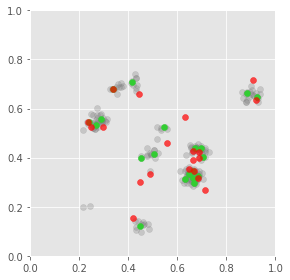

Acceptance rate: 0.7326881182814899
Energy diff: -0.00004344


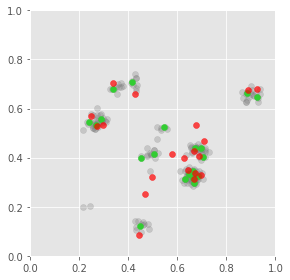

Acceptance rate: 0.7346088463717876
Energy diff: -0.00000737


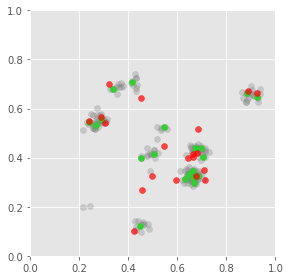

Acceptance rate: 0.7338833161463705
Energy diff: -0.00002431


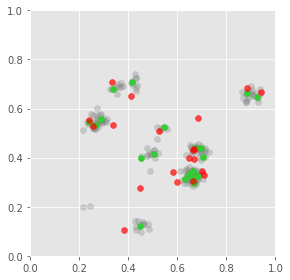

Acceptance rate: 0.7347430957913003
Energy diff: -0.00007270


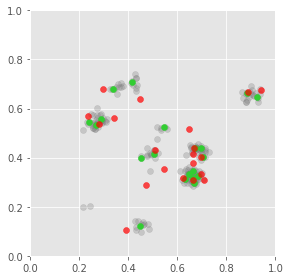

Acceptance rate: 0.733840726646482
Energy diff: -0.00003055


In [ ]:
RUN_MH = 1
RUN_DIFFUSION = 1
PLOT = 1

if RUN_MH:
    # Sampling parameters.
    STEP_SIZE = 1e-3
    NUM_Y_TILDES = 200
    ALPHA = 10000

    METHOD = 'mh'
    print('\n\n--------- RUNNING {} ----------\n'.format(METHOD.upper()))
    (y_tildes_mh,
     energies_mh,
     _) = sample_sp_exp_mech(e_opt, energy_sensitivity, x, y_opt,
                             METHOD, STEP_SIZE, NUM_Y_TILDES, ALPHA,
                             plot=PLOT)

if RUN_DIFFUSION:
    # Sampling parameters.
    STEP_SIZE = 1e-2
    NUM_Y_TILDES = 200
    ALPHA = 5
    
    METHOD = 'diffusion'
    print('\n\n--------- RUNNING {} ----------\n'.format(METHOD.upper()))
    (y_tildes_diffusion,
     energies_diffusion,
     energy_estimation_errors_diffusion) = sample_sp_exp_mech(e_opt,
                                                              energy_sensitivity,
                                                              x, y_opt, METHOD,
                                                              STEP_SIZE, NUM_Y_TILDES,
                                                              ALPHA)

In [ ]:
# Plot results of sampling for private support points.
if PLOT:
    if RUN_MH:
        #plt.title('Energies with MH, {} samples'.format(len(energies_mh)))
        plt.hist(energies_mh, bins=20, alpha=0.3, density=True)
        
        
        # Compare to Exponential density.
        p = exponential_param = 2. * energy_sensitivity / ALPHA
        xs = np.linspace(0, np.max(energies_mh), 100)
        xs_dens = 1 / p * np.exp(-xs / p)
        plt.plot(xs, xs_dens, c='gray')
        plt.xlabel(r'Energy, $e(y, \tilde{y})$', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)

        plt.tight_layout()
        plt.savefig('../output/fig_mh_energies.png')
        plt.show()
        print('p: {}'.format(p))


    if RUN_DIFFUSION:
        #plt.title('Energies with Diffusion, {} samples'.format(len(energies_diffusion)))
        plt.hist(energies_diffusion, bins=20, alpha=0.3, density=True)
        plt.xlabel(r'Energy, $e(y, \tilde{y})$', fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        
        # Compare to Exponential density.
        p = exponential_param = 2. * energy_sensitivity / ALPHA
        x = np.linspace(0, np.max(energies_diffusion), 100)
        x_dens = 1 / p * np.exp(-x / p)
        plt.plot(x, x_dens, c='gray')
        plt.tight_layout()
        plt.savefig('../output/fig_diffusion_energies.png')
        plt.show()
        print('p: {}'.format(p))
        
        # Scatter plot the errors.
        errs = energy_estimation_errors_diffusion
        plt.scatter(errs[:, 0], errs[:, 1])
        plt.xlabel(r'Energy, $e(y, \tilde{y})$', fontsize=14)
        plt.ylabel(r'Relative error: $(e(y, \tilde{y}) - \tilde{e}) \, / \, \tilde{e}$',
                   fontsize=14)
        plt.tight_layout()
        plt.savefig('../output/fig_diffusion_energy_errors.png')
        plt.show()

    # Compare to energies of e(y_opt, uniform)
    baseline_energies = np.zeros(NUM_Y_TILDES)
    for i in range(NUM_Y_TILDES):
        e_, _ = energy(y_opt, np.random.uniform(size=y_opt.shape))
        baseline_energies[i] = e_
    plt.title('Energies with UNIFORM, n={}'.format(len(baseline_energies)))
    plt.hist(baseline_energies, bins=20, alpha=0.3)
    plt.show()

In [ ]:
pdb.set_trace()

#### Paper: Figure of private support point samples with various alphas.

In [ ]:
example_alphas = [1, 10, 100, 1000]
step_sizes = [0.25, 1e-2, 1e-2, 1e-3]
n_alp = len(example_alphas)
fig, axs = plt.subplots(1, n_alp, figsize=(3 * n_alp, 3))
for i, alpha in enumerate(example_alphas):
    (y_tildes_diffusion,
     energies_diffusion) = sample_sp_exp_mech(e_opt, energy_sensitivity,
                                              x, y_opt, METHOD,
                                              step_size=step_sizes[i],
                                              num_y_tildes=1,
                                              alpha=alpha,
                                              diffusion_mean=True)

    axs[i].set_title(r'$\alpha$={}, e={:.4f}'.format(alpha,
                                                     energies_diffusion[0]))
    axs[i].scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3)
    axs[i].scatter(y_opt[:, 0], y_opt[:, 1], c='green', alpha=0.7)
    axs[i].scatter(y_tildes_diffusion[0, :, 0],
                   y_tildes_diffusion[0, :, 1],
                   c='red', alpha=0.7)
    axs[i].set_xlim((0, 1))
    axs[i].set_ylim((0, 1))
        
plt.subplots_adjust(wspace=0.2, hspace=0.2,
                    bottom=0.1, top=0.9, left=0.05, right=0.95)
plt.savefig('../output/fig_sp_different_alphas.png')

___

# 6. Expand to full data set.

## 6.0 KDE with pre-selected bandwidth.

#### Given privately sampled (by diffusion) SP, expand them using KDE and pre-selected bandwidth.

In [ ]:
# Show data and y_tilde.
NUM_Y_TILDES = 1
METHOD = 'diffusion'
FULL_SAMPLE_SIZE = M
STEP_SIZE = 1e-2

(y_tilde,
 y_tilde_upsampled,
 y_tilde_expansion,
 energy_y_y_tilde) = sample_full_set_by_diffusion(e_opt, energy_sensitivity,
                                                  x, y_opt, STEP_SIZE, ALPHA,
                                                  SIGMA_DATA, FULL_SAMPLE_SIZE, 
                                                  plot=True)

## 6.1 KDE with DP-MLE bandwidth.

#### Compute likelihood over a range of bandwidths, and compute likelihood for each.

In [ ]:
# Find optimal bandwidth using Maximum Likelihood.
NUM_BANDWIDTHS = 20
BW_HIGH, BW_LOW = 0.01, 0.0001
BW_RANGE = np.linspace(BW_HIGH, BW_LOW, NUM_BANDWIDTHS)
PLOT = 1

# Store bandwidth and likelihood pairs.
bw_lik = np.zeros((NUM_BANDWIDTHS, 2))

# Measure data likelihood under models centered on private support
# points, with a range of bandwidths.
for i, bw in enumerate(BW_RANGE):    
    lik, do_log = mixture_model_likelihood(x, y_tilde, bw)
    
    bw_lik[i] = [bw, lik]


# Print and plot all bandwidth-likelihood pairs.
bw_best, bw_best_lik = bw_lik[np.argmax(bw_lik, axis=0)[1]]
bw_worst, bw_worst_lik = bw_lik[np.argmin(bw_lik, axis=0)[1]]

In [ ]:
# Plot results for various bandwidths.
lik_str = 'llik' if do_log else 'lik'
for bw, lik in bw_lik:
    print('bw: {:.6f}, {}: {:.2e}'.format(bw, lik_str, lik))
plt.plot(bw_lik[:, 0], bw_lik[:, 1])
plt.scatter(bw_best, bw_best_lik, label='max lik')
plt.xlabel('bandwidth')
plt.ylabel(lik_str)
plt.title('MLE, bw={:.6f}, {}={:.3e}'.format(bw_best, lik_str, bw_best_lik))
plt.legend()
plt.show()

#### Show samples with best and worst bandwidth.

In [ ]:
# Compare to likelihoods of data and optimal support points.
lik_y_opt, _ = mixture_model_likelihood(x, y_opt, bw_best,
                                        tag='y_opt, best bw: ')
lik_y_tilde, _ = mixture_model_likelihood(x, y_tilde, bw_best,
                                          tag='y_tilde, best bw: ')

print('do_log: {}'.format(do_log))
print('P(x | y_opt, bw_best): {:.2e}'.format(lik_y_opt))
print('P(x | y_tilde, bw_best): {:.2e}'.format(lik_y_tilde))


# Plot results.
new_sample = (
    y_tilde_upsampled + np.random.normal(0, bw_best,
                                         size=(FULL_SAMPLE_SIZE, x.shape[1])))
new_sample_worst = (
    y_tilde_upsampled + np.random.normal(0, bw_worst,
                                         size=(FULL_SAMPLE_SIZE, x.shape[1])))


if PLOT:
    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    plt.scatter(y_opt[:, 0], y_opt[:, 1], c='green', alpha=0.7,
                label='sp(data)')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7,
                label='~sp(data)')
    plt.scatter(new_sample[:, 0], new_sample[:, 1], c='blue', alpha=0.3,
                label='FULL')

    plt.title('BEST new sample, by {}, bw={:.6f}, lik={:.2e}'.format(
        'diffusion', bw_best, bw_best_lik))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    plt.scatter(y_opt[:, 0], y_opt[:, 1], c='green', alpha=0.7,
                label='sp(data)')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7,
                label='~sp(data)')
    plt.scatter(new_sample_worst[:, 0], new_sample_worst[:, 1], c='blue',
                alpha=0.3, label='FULL')

    plt.title('WORST new sample, by {}, bw={:.6f}, lik={:.2e}'.format(
        'diffusion', bw_worst, bw_worst_lik))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

#### Sample full synthetic set with DP sample of MLE bandwidth.

In this setting, for positive bandwidth $\sigma$, Gaussian data up to $4\sigma$ is bounded on $[0, 1]$ by restricting cluster centers to $[0 + 4\sigma, 1 - 4\sigma]$. The largest $\sigma$ that accommodates this bound is $\sigma = 1/8$. With sensitivity $\Delta f = 1/8$, we sample a DP bandwidth $\tilde{\sigma} \sim \mbox{Lap}(\sigma, \frac{1/8}{\alpha})$, and enforce a non-trivially small positive floor value $\delta$, with $\max(\tilde{\sigma}, \delta)$.

In [ ]:
floor = 1e-4
dp_bandwidth_raw = bw_best + np.random.laplace(loc=0, scale=(1 / 8) / ALPHA)
dp_bandwidth = np.max([dp_bandwidth_raw, floor])
print('Best bw: {:>14.4f}\nraw DP bw: {:>12.4f}\nCorrected DP bw: {:>1.4f}'.format(
        bw_best, dp_bandwidth_raw, dp_bandwidth))

(y_tilde,
 y_tilde_upsampled,
 y_tilde_expansion,
 energy_y_y_tilde) = sample_full_set_by_diffusion(e_opt, energy_sensitivity,
                                                  x, y_opt, STEP_SIZE, ALPHA,
                                                  dp_bandwidth, FULL_SAMPLE_SIZE, 
                                                  plot=True)

## 6.2 KDE with DP median of pairwise distances as bandwidth.

Choose W based on data (median heuristics). Add DP noise to W, i.e. add $\eta \sim \mbox{Lap}(2^{(1/p)} / 2)$. Get SP with MMD_W. Do KDE with W.

In [ ]:
if 0:
    # Show data and y_tilde.
    NUM_Y_TILDES = 1
    METHOD = 'diffusion'
    SAMPLE_SIZE = M
    STEP_SIZE = 2e-3

    # Compute median of pairwise distanes, and use that as bandwidth.
    median_pairwise_dists = np.median(pdist(x, 'minkowski', p=ENERGY_POWER))
    sensitivity_median_pairwise_dists = DIM ** (1. / ENERGY_POWER) / 2.
    private_median = median_pairwise_dists + np.random.laplace(
        scale=sensitivity_median_pairwise_dists / ALPHA)
    print(median_pairwise_dists)
    print(private_median)
    #pdb.set_trace()

    """
    (y_tilde,
     y_tilde_upsampled,
     y_tilde_expansion,
     energy_y_y_tilde) = sample_full_set_by_diffusion(e_opt, energy_sensitivity,
                                                      x, y_opt, STEP_SIZE, ALPHA,
                                                      private_median, SAMPLE_SIZE)

    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7, label='~sp(data)')
    plt.scatter(y_tilde_expansion[:, 0], y_tilde_expansion[:, 1], c='blue', 
                alpha=0.3, label='FULL')

    plt.title('{}, and PRE-SELECTED w = {}'.format(METHOD, BANDWIDTH))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    """

## 6.3 Repeated draws of private support points.

In [ ]:
if 1:
    NUM_REPEATS = int(M / N) + 1
    new_sample = []
    STEP_SIZE = 1e-2

    #print('NOTE: CHANGED ALPHA!')
    #ALPHA = NUM_REPEATS * ALPHA

    for i in range(NUM_REPEATS):
        (y_tilde,
         y_tilde_upsampled,
         y_tilde_expansion,
         energy_y_y_tilde) = sample_full_set_by_diffusion(e_opt, energy_sensitivity,
                                                          x, y_opt, STEP_SIZE,
                                                          ALPHA, BANDWIDTH,
                                                          FULL_SAMPLE_SIZE)
        new_sample.append(y_tilde)

    print('\nConcatenating results, and plotting collection of samples as one.\n')

    new_sample = np.concatenate(new_sample)

    plt.scatter(x[:, 0], x[:, 1], c='gray', alpha=0.3, label='data')
    # plt.scatter(y_tilde[:, 0], y_tilde[:, 1], c='red', alpha=0.7, label='~sp(data)')
    plt.scatter(new_sample[:, 0], new_sample[:, 1], c='red', alpha=0.3, label='FULL')

    plt.title('{}, alpha={}, repeats={}, budget={},\n n={}, bw={}'.format(
        METHOD, ALPHA, NUM_REPEATS, ALPHA * float(NUM_REPEATS), len(new_sample),
        BANDWIDTH))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.xlim(0, 1)
    #plt.ylim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# End.